# Overall Summary (tldr):
## Conserved Plasticity:
- Overall we see that out of 111 conserved plastic genes, 90 (81%) move in the same direction as ancestral lines. 
- More genes had a more intense response in the salt-adapted lines compared to ancestral lines, but not by much
## Evolved Plasticity Summary:
- Overall we see that average expression increased 2.055 L2F in salt-adapted lines
- Only 97/210 genes (46%) retained their DE status from 0-5g/L into 5-36g/L NaCl
## Lost Plasticity Summary
- Overall we see that almost double the number of genes are closer to ancestral basal expression levels 
- For that were not fixed at an ancestral level (384; 77%):
    - 66% Were up-regulated in the ancestral condition, i.e. A5 expression was higher than A0 Expression
    - 54% Were found to be expressed against the trend that the ancestors had, suggesting a reversion to the plastic response (i.e. the ancestral response was maladaptive and pushed fitness in the wrong direction)
    - 36% (92+45) Were found to benifit from the ancestral response to reinforce or tweak the ancestral response

# Load Required Libraries

In [1]:
library(DESeq2)
library(dplyr)
library(ggplot2)
library(wesanderson)
library(viridis)
library(ggsci)
library(gplots)
sessionInfo()
options(repr.plot.width=16, repr.plot.height=8) #make all the plots larger

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/paulyeta/.conda/envs/r4-base/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gplots_3.1.1                ggsci_2.9                  
 [3] viridis_0.6.2               viridisLite_0.4.1          
 [5] wesanderson_0.3.6           ggplot2_3.3.6              
 [7] dplyr_1.0.9                 DESeq2_1.30.1              
 [9] SummarizedExperiment_1.20.0 B

# DESeq2
## Loading data and organizing groups

In [2]:
se<-readRDS("../Reference_Files/DE_Analysis/read_count_table.SE")
se$run<-colnames(se)
sampleInfo <- read.csv("../Reference_Files/DE_Analysis/sampleInfo_Ancestors.csv") #parent is combined as an ancestor
sampleInfo$sample_nested <- ifelse(sampleInfo$sample == 2935, yes = "C", no = sampleInfo$sample_nested)
sampleInfo$levels <- ifelse(sampleInfo$selection == "salt" & 
                            (sampleInfo$assay_conc == 0 | sampleInfo$assay_conc == 5), 
                            yes = "saltgroup", no = "A")
sampleInfo$levels <- ifelse(sampleInfo$selection == "ancestor" & sampleInfo$assay_conc == 0, 
                            yes = "ancestor0", no = sampleInfo$levels)
sampleInfo$levels <- ifelse(sampleInfo$selection == "ancestor" & sampleInfo$assay_conc == 5, 
                            yes = "ancestor5", no = sampleInfo$levels)
head(sampleInfo)
sampleInfo <- DataFrame(sampleInfo)
sampleInfo$run<-as.character(sampleInfo$run)
sampleInfo$sample<-as.factor(as.character(sampleInfo$sample))
sampleInfo$assay_conc<-as.factor(as.character(sampleInfo$assay_conc))
seIdx <- match(colnames(se), sampleInfo$run)
colData(se) <- cbind(colData(se), sampleInfo[seIdx,])

#A + salt = 23
#A + ancestor = 40
#B + salt = 29
#B + ancestor = 54

,run,selection,assay_conc,sample,sample_nested,levels
,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,23_00_1.RG.bam,salt,0,23,A,saltgroup
2,23_00_2.RG.bam,salt,0,23,A,saltgroup
3,23_00_3.RG.bam,salt,0,23,A,saltgroup
4,23_05_1.RG.bam,salt,5,23,A,saltgroup
5,23_05_2.RG.bam,salt,5,23,A,saltgroup
6,23_05_3.RG.bam,salt,5,23,A,saltgroup


## Building the model + Creating the dataset

In [3]:
model <- model.matrix(~selection + selection:sample_nested + selection:assay_conc, sampleInfo)
all.zero <- apply(model, 2, function(x) all(x==0))
all.zero

model <- model[,-which(all.zero)]
dim(model)

(Intercept)                    selectionsalt 
                           FALSE                            FALSE 
selectionancestor:sample_nestedB     selectionsalt:sample_nestedB 
                           FALSE                            FALSE 
selectionancestor:sample_nestedC     selectionsalt:sample_nestedC 
                           FALSE                             TRUE 
  selectionancestor:assay_conc36       selectionsalt:assay_conc36 
                            TRUE                            FALSE 
   selectionancestor:assay_conc5        selectionsalt:assay_conc5 
                           FALSE                            FALSE

[1] 36  8

In [4]:
dds_subset <- DESeqDataSet(se, design = model)
#set 0 as control so that everything will be relative to 0
#ancestor is already the default control here
dds_subset$assay_conc <- relevel(dds_subset$assay_conc, "0")

head(as.data.frame(colData(dds_subset)))

,run,run.1,selection,assay_conc,sample,sample_nested,levels
,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>
23_00_1.RG.bam,23_00_1.RG.bam,23_00_1.RG.bam,salt,0,23,A,saltgroup
23_00_2.RG.bam,23_00_2.RG.bam,23_00_2.RG.bam,salt,0,23,A,saltgroup
23_00_3.RG.bam,23_00_3.RG.bam,23_00_3.RG.bam,salt,0,23,A,saltgroup
23_05_1.RG.bam,23_05_1.RG.bam,23_05_1.RG.bam,salt,5,23,A,saltgroup
23_05_2.RG.bam,23_05_2.RG.bam,23_05_2.RG.bam,salt,5,23,A,saltgroup
23_05_3.RG.bam,23_05_3.RG.bam,23_05_3.RG.bam,salt,5,23,A,saltgroup


## Run DESeq

In [5]:
dds <- DESeq(dds_subset, betaPrior=FALSE)
resultsNames(dds)
result_subset<-results(dds)
mcols(result_subset, use.names=TRUE) #explains what the values are 

using supplied model matrix

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                        "selectionsalt"                   
[3] "selectionancestor.sample_nestedB" "selectionsalt.sample_nestedB"    
[5] "selectionancestor.sample_nestedC" "selectionsalt.assay_conc36"      
[7] "selectionancestor.assay_conc5"    "selectionsalt.assay_conc5"

DataFrame with 6 rows and 2 columns
                       type            description
                <character>            <character>
baseMean       intermediate mean of normalized c..
log2FoldChange      results log2 fold change (ML..
lfcSE               results standard error: sele..
stat                results Wald statistic: sele..
pvalue              results Wald test p-value: s..
padj                results   BH adjusted p-values

|Term| Explaination|
|---|---|
|`selectionsalt`|Overall salt vs ancestors (salt/ancestors) @0|
|`selectionancestor.sample_nestedB`|Comparison within ancestral lines; Sample54@0/Sample40@0|
|`selectionsalt.sample_nestedB`|Comparison within salt lines; Sample23@0/Sample29@0|
|`selectionancestor.sample_nestedC`|Comparison within ancestral lines; Sample2935@0/Sample40@0|
|`selectionsalt.assay_conc36`|Comparison of salt condition; Salt@36/Salt@0|
|`selectionancestor.assay_conc5`|Comparison of ancestral condition; Ancestor@5/Ancestor@0|
|`selectionsalt.assay_conc5`|Comparison of salt condition; Salt@5/Salt@0|

# Examining Relationships

## PCA

In [6]:
rld <- rlog(dds, blind = F)
head(rld)

rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation



class: DESeqTransform 
dim: 6 36 
metadata(1): version
assays(1): ''
rownames(6): ADF43159.1 ADF43160.1 ... ADF43163.1 ADF43164.1
rowData names(47): baseMean baseVar ... maxCooks rlogIntercept
colnames(36): 23_00_1.RG.bam 23_00_2.RG.bam ... 54_05_2.RG.bam
  54_05_3.RG.bam
colData names(8): run run.1 ... levels sizeFactor

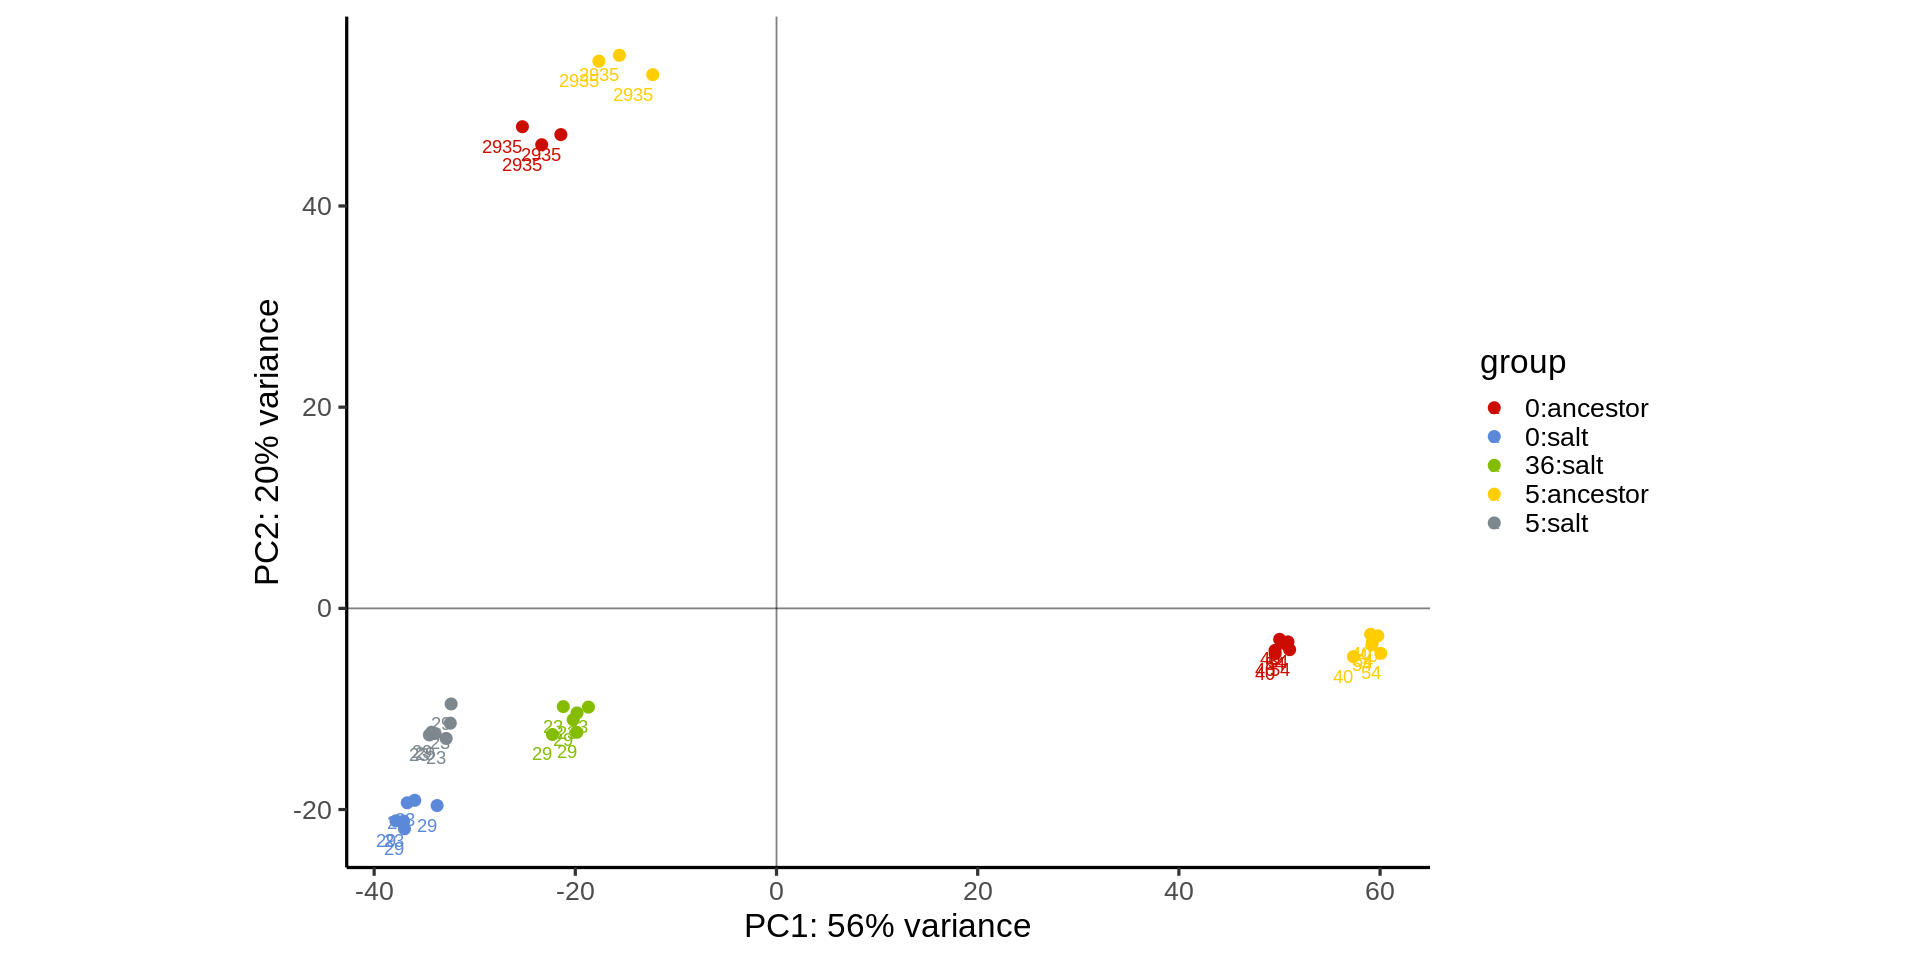

In [7]:
plotPCA(rld, intgroup=c("assay_conc", "selection")) + theme_classic(base_size = 20) + geom_hline(yintercept = 0, alpha = 0.5) + 
    geom_vline(xintercept = 0, alpha = 0.5) + scale_color_startrek() + geom_text(aes(label=rld$sample,hjust=1,vjust=2))

In [8]:
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld$selection, rld$assay_conc, rld$sample, sep="-")
colnames(sampleDistMatrix) <- paste(rld$selection, rld$assay_conc, rld$sample, sep="-")

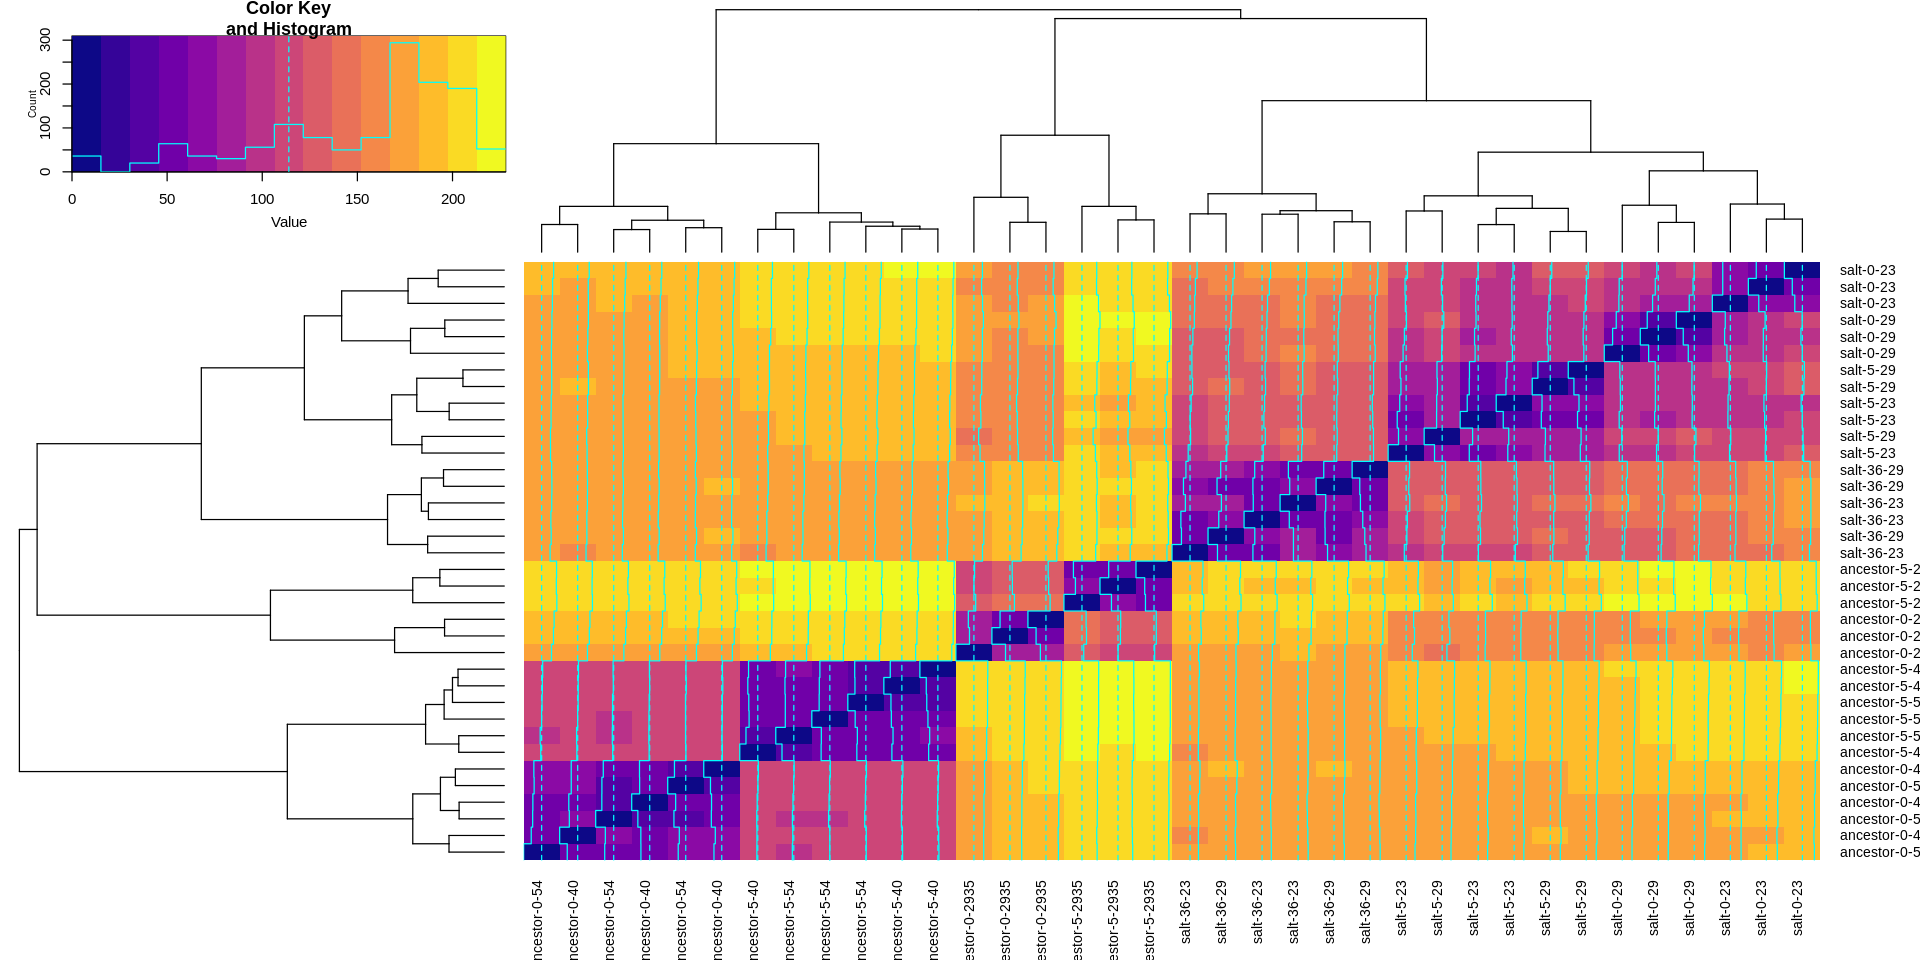

In [9]:
heatmap.2(sampleDistMatrix, col=viridis_pal(option = "C"))

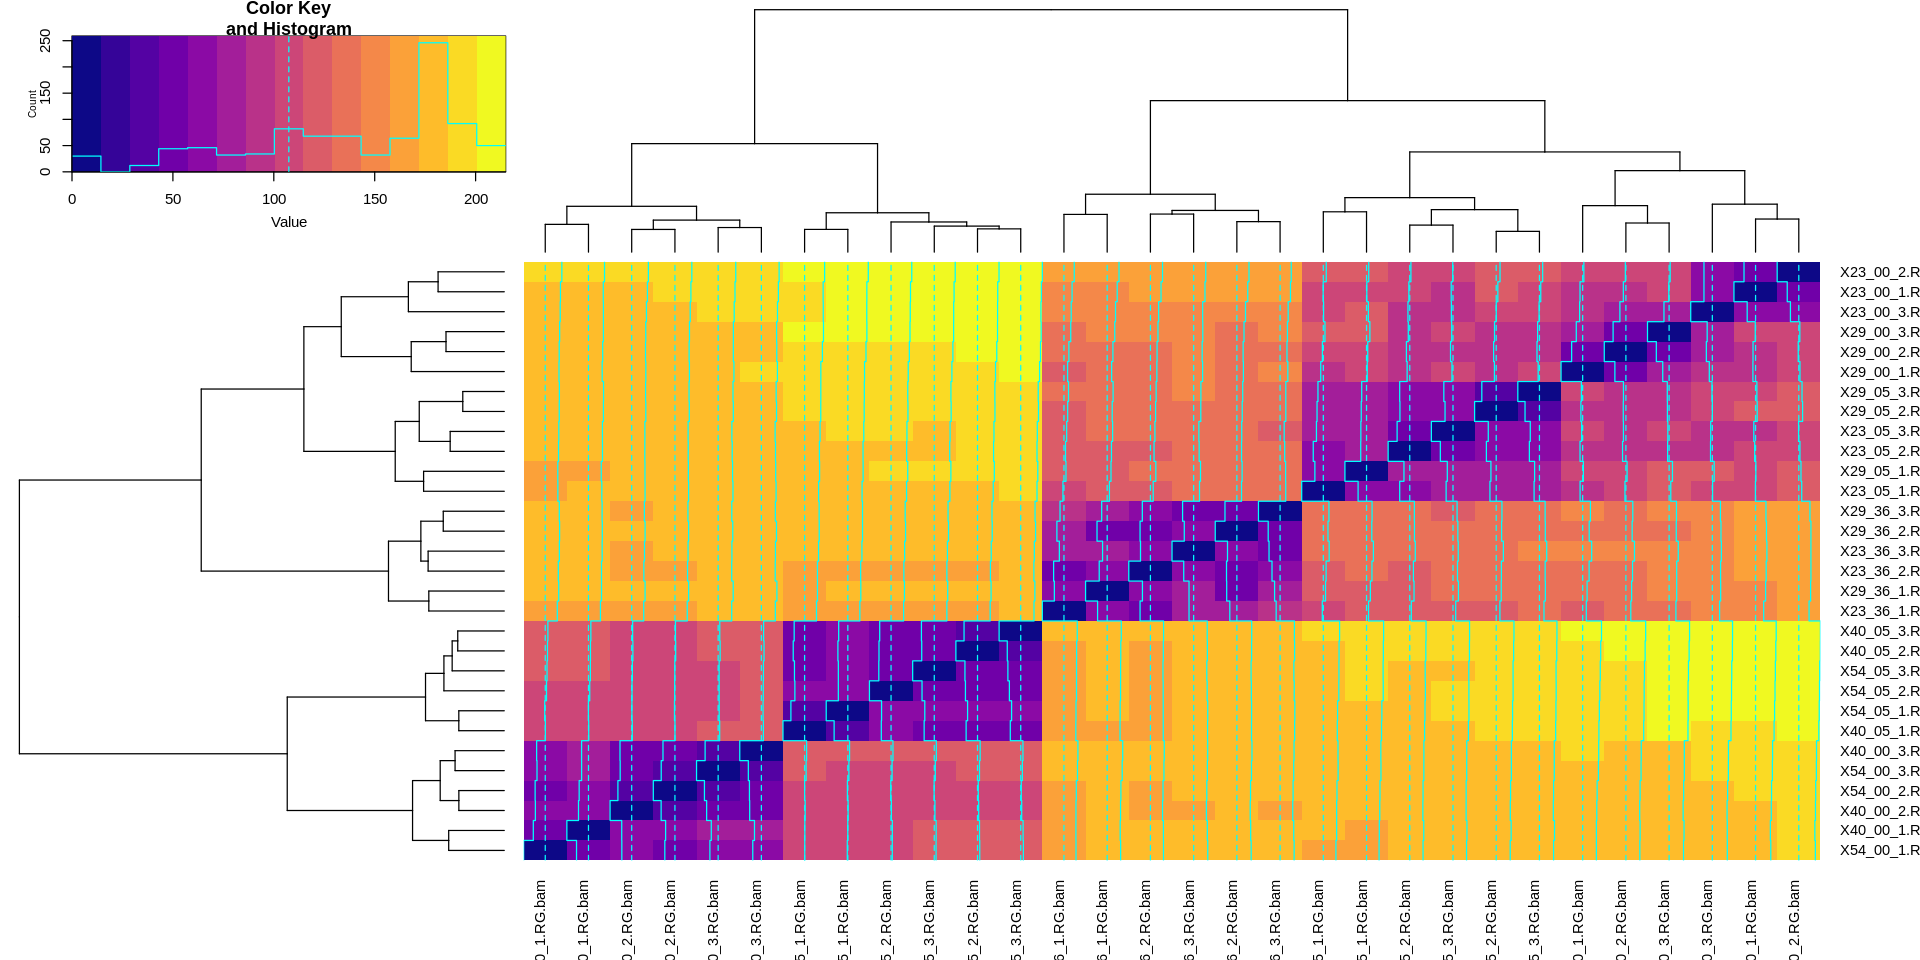

In [10]:
data.frame(assay(rld)) %>%
    select(!contains("2935")) %>%
    t()%>%
    dist() %>%
    as.matrix %>%
    heatmap.2(col=viridis_pal(option = "C"))

# Determine Patterns of Expression
## Get Ancestors expression change from 0 to 5g/L NaCl

In [11]:
res_A05_temp <- results(dds, name = "selectionancestor.assay_conc5")
#remove empty rows
res_A05_temp_filtered<-res_A05_temp[!is.na(res_A05_temp$padj),]
dim(res_A05_temp_filtered)

#index to get required columns
res_A05 <- as.data.frame(cbind(res_A05_temp_filtered[,2], res_A05_temp_filtered[,6]))
rownames(res_A05) <- rownames(res_A05_temp_filtered)
colnames(res_A05) <- c("LFC", "padj")

# Label by Differential expression criteria
res_A05$DE <- ifelse(abs(res_A05$LFC) >= 2 & res_A05$padj <= 0.05, yes = TRUE, no = FALSE)
head(res_A05)
table(res_A05$DE)

[1] 17004     6

,LFC,padj,DE
,<dbl>,<dbl>,<lgl>
ADF43159.1,-0.5663565,0.032143729,FALSE
ADF43160.1,-0.6059629,0.043219971,FALSE
ADF43161.1,-1.0570990,0.131792111,FALSE
ADF43162.1,-0.2043064,0.184702303,FALSE
ADF43163.1,-0.1409970,0.611268669,FALSE
ADF43164.1,-1.0807191,0.003635367,FALSE



FALSE  TRUE 
16392   612 

## Get salt-adapted expression change from 0 to 5g/L NaCl

In [12]:
res_S05_temp <- results(dds, name = "selectionsalt.assay_conc5")
#remove empty rows
res_S05_temp_filtered<-res_S05_temp[!is.na(res_S05_temp$padj),]
dim(res_S05_temp_filtered)

#index to get required columns
res_S05 <- as.data.frame(cbind(res_S05_temp_filtered[,2], res_S05_temp_filtered[,6]))
rownames(res_S05) <- rownames(res_S05_temp_filtered)
colnames(res_S05) <- c("LFC", "padj")

# Label by Differential expression criteria
res_S05$DE <- ifelse(abs(res_S05$LFC) >= 2 & res_S05$padj <= 0.05, yes = TRUE, no = FALSE)
head(res_S05)
table(res_S05$DE)

[1] 17004     6

,LFC,padj,DE
,<dbl>,<dbl>,<lgl>
ADF43159.1,0.44931068,0.17330661,FALSE
ADF43160.1,0.94047913,0.00456503,FALSE
ADF43161.1,0.08180232,0.94945212,FALSE
ADF43162.1,0.04775834,0.85427467,FALSE
ADF43163.1,-0.21822685,0.51606023,FALSE
ADF43164.1,0.60785173,0.14469060,FALSE



FALSE  TRUE 
16586   418 

## Merge dataframes and group by patterns

In [13]:
all_expression <- merge(res_A05, res_S05, by = 0, suffixes = c("_A", "_S"))
rownames(all_expression) <- all_expression$Row.names
head(all_expression)
dim(all_expression)

,Row.names,LFC_A,padj_A,DE_A,LFC_S,padj_S,DE_S
,<I<chr>>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>
ADF43159.1,ADF43159.1,-0.5663565,0.032143729,FALSE,0.44931068,0.17330661,FALSE
ADF43160.1,ADF43160.1,-0.6059629,0.043219971,FALSE,0.94047913,0.00456503,FALSE
ADF43161.1,ADF43161.1,-1.0570990,0.131792111,FALSE,0.08180232,0.94945212,FALSE
ADF43162.1,ADF43162.1,-0.2043064,0.184702303,FALSE,0.04775834,0.85427467,FALSE
ADF43163.1,ADF43163.1,-0.1409970,0.611268669,FALSE,-0.21822685,0.51606023,FALSE
ADF43164.1,ADF43164.1,-1.0807191,0.003635367,FALSE,0.60785173,0.14469060,FALSE


[1] 17004     7

In [14]:
all_expression$Pattern <- ifelse(all_expression$DE_A & all_expression$DE_S, yes = "Conserved Plasticity", no = "Constitutive")
all_expression$Pattern <- ifelse(all_expression$DE_A & !all_expression$DE_S, yes = "Loss of Plasticity", no = all_expression$Pattern)
all_expression$Pattern <- ifelse(!all_expression$DE_A & all_expression$DE_S, yes = "Evolved Plasticity", no = all_expression$Pattern)

table(all_expression$Pattern)


Conserved Plasticity         Constitutive   Evolved Plasticity 
                 111                16085                  307 
  Loss of Plasticity 
                 501 

### Exporting gene lists

In [70]:
write.csv(rownames(all_expression[all_expression$Pattern == "Conserved Plasticity",]), 
          file = "Conserved Plasticity Genes.csv", row.names=FALSE, quote=FALSE)
write.csv(rownames(all_expression[all_expression$Pattern == "Constitutive",]), 
          file = "Constitutive Genes.csv", row.names=FALSE, quote=FALSE)
write.csv(rownames(all_expression[all_expression$Pattern == "Loss of Plasticity",]), 
          file = "Loss of Plasticity Genes.csv", row.names=FALSE, quote=FALSE)
write.csv(rownames(all_expression[all_expression$Pattern == "Evolved Plasticity",]),
          "Evolved Plasticity Genes.csv",row.names=FALSE, quote=FALSE)

## Create Significance Plot


Ancestor     Both  Evolved  Neither 
    4699     2551     2376     7378 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 36 rows containing missing values (geom_point).”


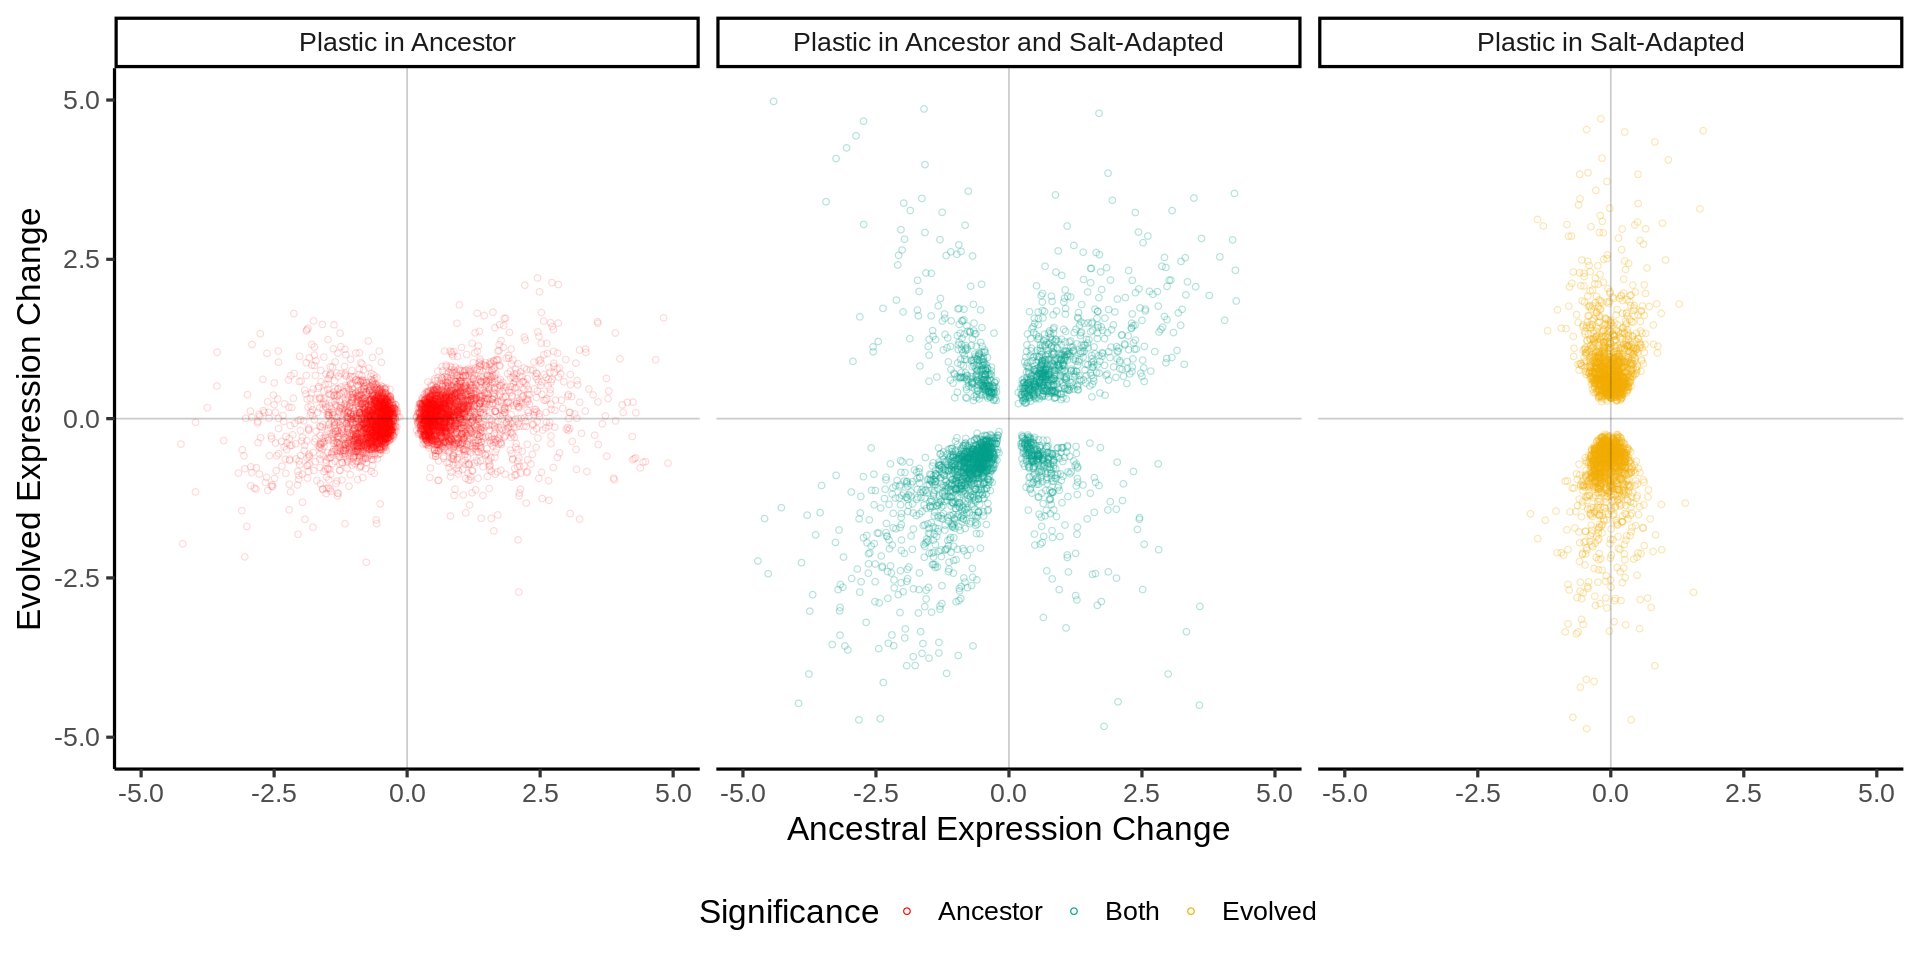

In [15]:
#Sort Significance by pvalue
all_expression$Significance <- ifelse(all_expression$padj_A <= 0.05 & all_expression$padj_S <= 0.05, yes = "Both", no = "Neither")
all_expression$Significance <- ifelse(all_expression$padj_A > 0.05 & all_expression$padj_S <= 0.05, yes = "Evolved", no = all_expression$Significance)
all_expression$Significance <- ifelse(all_expression$padj_A <= 0.05 & all_expression$padj_S > 0.05, yes = "Ancestor", no = all_expression$Significance)
table(all_expression$Significance)

#Assign transparency values based on groups
all_expression$Alpha <- ifelse(all_expression$Significance == "Ancestor", yes = 0.15, no = 0.3)

#Set up a palette
patternColors <- #Make neither grey
  setNames(c("#FF0000","#00A08A", "#F2AD00"), c("Ancestor","Both", "Evolved"))

#Set up informative labels
significance.labs <- c("Plastic in Ancestor", "Plastic in Ancestor and Salt-Adapted", "Plastic in Salt-Adapted")
names(significance.labs) <- c("Ancestor", "Both", "Evolved")

#Run ggplot with only the significance levels
ggplot(data = all_expression[all_expression$Significance != "Neither",], aes(x=LFC_A, y=LFC_S, color = Significance, alpha = Alpha)) +
    theme_classic(base_size = 20)+
    geom_point(shape = 1) +
    theme(legend.position="bottom")+
    geom_hline(yintercept = 0, color = "black", linetype = "solid", alpha = 0.2)+
    geom_vline(xintercept = 0, color = "black", linetype = "solid", alpha = 0.2)+
    xlim(-5,5)+
    ylim(-5,5)+
    xlab("Ancestral Expression Change")+ 
    ylab("Evolved Expression Change")+
    scale_alpha_identity()+
    guides(alpha = FALSE) + 
    scale_color_manual(values = patternColors)+
    facet_grid(~Significance, labeller = labeller(Significance = significance.labs))

# Conserved Plasticity
Genes that display conserved plasticity are plastic in both ancestral and salt-adapted lines. For genes that display conserved plasticity:
- How is the plasticity different in salt-adapted lines from the ancestral lines?
    - Do they have the same directionality of expression?
    - Which is more intense?

In [16]:
conserved_plasticity <- all_expression[all_expression$Pattern == "Conserved Plasticity", ]
dim(conserved_plasticity)
head(conserved_plasticity)

[1] 111  10

,Row.names,LFC_A,padj_A,DE_A,LFC_S,padj_S,DE_S,Pattern,Significance,Alpha
,<I<chr>>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>
Cre01.g016600,Cre01.g016600,-2.030047,5.139963e-06,TRUE,2.965613,1.741129e-07,TRUE,Conserved Plasticity,Both,0.3
Cre01.g025200,Cre01.g025200,-3.321342,1.222987e-09,TRUE,-3.545741,8.257032e-08,TRUE,Conserved Plasticity,Both,0.3
Cre01.g028850,Cre01.g028850,-2.519864,3.481914e-25,TRUE,-2.872093,6.608228e-23,TRUE,Conserved Plasticity,Both,0.3
Cre01.g033500,Cre01.g033500,2.020932,1.194303e-05,TRUE,-2.503436,2.317632e-05,TRUE,Conserved Plasticity,Both,0.3
Cre01.g042700,Cre01.g042700,-3.210722,3.238200e-14,TRUE,-2.683187,2.187903e-09,TRUE,Conserved Plasticity,Both,0.3
Cre01.g053000,Cre01.g053000,3.962902,6.338615e-131,TRUE,2.538866,7.101062e-35,TRUE,Conserved Plasticity,Both,0.3


In [17]:
dim(conserved_plasticity[conserved_plasticity$LFC_A < 0,])
dim(conserved_plasticity[conserved_plasticity$LFC_A > 0,])
dim(conserved_plasticity[conserved_plasticity$LFC_S < 0,])
dim(conserved_plasticity[conserved_plasticity$LFC_S > 0,])

#Both negative direction
conserved_plasticity$direction <- ifelse(conserved_plasticity$LFC_A < 0 & conserved_plasticity$LFC_S < 0, 
                                        yes = "Negative", no = "Paradoxical")

#Both Positive direction
conserved_plasticity$direction <- ifelse(conserved_plasticity$LFC_A > 0 & conserved_plasticity$LFC_S > 0, 
                                        yes = "Positive", no = conserved_plasticity$direction)
table(conserved_plasticity$direction)

[1] 74 10

[1] 37 10

[1] 69 10

[1] 42 10


   Negative Paradoxical    Positive 
         61          21          29 

In [18]:
conserved_plasticity$difference <- abs(conserved_plasticity$LFC_S) - abs(conserved_plasticity$LFC_A)
dim(conserved_plasticity[conserved_plasticity$difference > 0,]) #salt-adapted response was larger
dim(conserved_plasticity[conserved_plasticity$difference < 0,]) #salt-adapted response was smaller
summary(conserved_plasticity$difference)

[1] 61 12

[1] 50 12

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.4856 -0.5124  0.1198  0.2099  0.6318  4.1579 

## Conserved Plasticity Summary:
- Overall we see that out of 111 conserved plastic genes, 90 (81%) move in the same direction as ancestral lines. 
- More genes had a more intense response in the salt-adapted lines compared to ancestral lines, but not by much

# Evolved Plasticity
Genes that display evolved plasticity were not plastic in ancestral lines but evolved this plasticity in the salt-adapted lines. 
- Do these genes retain their DE status into 36g/L?

In [19]:
evolved_plasticity <- all_expression[all_expression$Pattern == "Evolved Plasticity", ]
dim(evolved_plasticity)
head(evolved_plasticity)

[1] 307  10

,Row.names,LFC_A,padj_A,DE_A,LFC_S,padj_S,DE_S,Pattern,Significance,Alpha
,<I<chr>>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>
Cre01.g004157,Cre01.g004157,-1.3166753,4.971050e-06,FALSE,-3.512263,1.031990e-24,TRUE,Evolved Plasticity,Both,0.3
Cre01.g007450,Cre01.g007450,-0.9419882,1.587168e-02,FALSE,2.727241,1.072541e-09,TRUE,Evolved Plasticity,Both,0.3
Cre01.g008250,Cre01.g008250,-0.1988886,6.480620e-01,FALSE,3.187962,1.718556e-13,TRUE,Evolved Plasticity,Evolved,0.3
Cre01.g009350,Cre01.g009350,-0.5793544,1.771024e-01,FALSE,3.450318,1.114412e-13,TRUE,Evolved Plasticity,Evolved,0.3
Cre01.g011150,Cre01.g011150,-1.5963884,2.201453e-04,FALSE,4.860021,5.823062e-21,TRUE,Evolved Plasticity,Both,0.3
Cre01.g012100,Cre01.g012100,-0.2356996,6.063159e-01,FALSE,2.109232,8.492395e-06,TRUE,Evolved Plasticity,Evolved,0.3


In [20]:
evolved_plasticity$difference <- abs(evolved_plasticity$LFC_S) - abs(evolved_plasticity$LFC_A)
summary(evolved_plasticity$difference)

#Average expression increased 2.055 L2F in salt-adapted lines

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1512  1.3504  1.8810  2.0552  2.4880  7.7955 

In [21]:
resS5_36_temp = as.data.frame(
    results(dds, 
            contrast=list("selectionsalt.assay_conc5", "selectionsalt.assay_conc36")))[, c("log2FoldChange", "padj")]
colnames(resS5_36_temp) <- c("LFC_5_36", "padj_5_36")
resS5_36<-resS5_36_temp[!is.na(resS5_36_temp$padj_5_36),]
resS5_36$DE_5_36 <- ifelse(abs(resS5_36$LFC_5_36) >= 2 & resS5_36$padj_5_36 <= 0.05, yes = TRUE, no = FALSE)
table(resS5_36$DE_5_36)
dim(resS5_36)
head(resS5_36)


FALSE  TRUE 
16554  1134 

[1] 17688     3

,LFC_5_36,padj_5_36,DE_5_36
,<dbl>,<dbl>,<lgl>
ADF43159.1,-0.5702877,3.850423e-02,FALSE
ADF43160.1,0.9019893,3.678110e-03,FALSE
ADF43161.1,5.1613423,1.638873e-12,TRUE
ADF43162.1,0.2301284,1.849642e-01,FALSE
ADF43163.1,-1.4013039,1.916662e-09,FALSE
ADF43164.1,0.5278089,1.628528e-01,FALSE


In [22]:
evolved_plasticity <- merge(evolved_plasticity[5:7], resS5_36, all.x = T, by = 0)
rownames(evolved_plasticity) <- evolved_plasticity$Row.names
dim(evolved_plasticity)
head(evolved_plasticity)

[1] 307   7

,Row.names,LFC_S,padj_S,DE_S,LFC_5_36,padj_5_36,DE_5_36
,<I<chr>>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>
Cre01.g004157,Cre01.g004157,-3.512263,1.031990e-24,TRUE,-0.5215183,1.837527e-01,FALSE
Cre01.g007450,Cre01.g007450,2.727241,1.072541e-09,TRUE,4.4050240,1.843769e-20,TRUE
Cre01.g008250,Cre01.g008250,3.187962,1.718556e-13,TRUE,4.6568214,2.270302e-25,TRUE
Cre01.g009350,Cre01.g009350,3.450318,1.114412e-13,TRUE,1.2601217,9.011739e-03,FALSE
Cre01.g011150,Cre01.g011150,4.860021,5.823062e-21,TRUE,5.5527470,2.742357e-27,TRUE
Cre01.g012100,Cre01.g012100,2.109232,8.492395e-06,TRUE,1.4096806,2.275665e-03,FALSE


In [23]:
evolved_plasticity$retained <- ifelse(evolved_plasticity$DE_S & evolved_plasticity$DE_5_36, yes = T, no = F)
table(evolved_plasticity$retained)


FALSE  TRUE 
  210    97 

## Evolved Plasticity Summary:
- Overall we see that average expression increased 2.055 L2F in salt-adapted lines
- Only 97/210 genes (46%) retained their DE status from 0-5g/L into 5-36g/L NaCl

# Lost Plasticity - Assimilation vs Compensation
If the basal expression of the salt-adapted lines at 0g/L is close to the ancestral basal expression at 0g/L then we can say those genes reverted to their basal ancestral level (genetic compensation is present). However, if expression is closer to that of salt-induced expression in ancestral lines at 5g/L then we can say those genes assimilated the ancestral expression level of expression. 

In [24]:
lost_plasticity <- all_expression[all_expression$Pattern == "Loss of Plasticity",]
dim(lost_plasticity)
head(lost_plasticity)

[1] 501  10

,Row.names,LFC_A,padj_A,DE_A,LFC_S,padj_S,DE_S,Pattern,Significance,Alpha
,<I<chr>>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>
ChreCp002,ChreCp002,2.513689,1.283282e-06,TRUE,0.5212137,0.6162462,FALSE,Loss of Plasticity,Ancestor,0.15
ChreCp003,ChreCp003,2.690047,9.148672e-06,TRUE,0.4561528,0.6886387,FALSE,Loss of Plasticity,Ancestor,0.15
ChreCp004,ChreCp004,3.362047,3.163727e-05,TRUE,1.0400616,0.5697483,FALSE,Loss of Plasticity,Ancestor,0.15
ChreCp005,ChreCp005,2.610868,9.355656e-06,TRUE,0.6469428,0.5167830,FALSE,Loss of Plasticity,Ancestor,0.15
ChreCp006,ChreCp006,3.092871,1.926531e-05,TRUE,0.3464021,0.8542160,FALSE,Loss of Plasticity,Ancestor,0.15
ChreCp008,ChreCp008,2.390832,2.001182e-07,TRUE,0.1025043,0.9259670,FALSE,Loss of Plasticity,Ancestor,0.15


## Get expression change between ancestors at 0g/L and salt-adapted lines at 0g/L

In [25]:
res_S0A0_temp <- results(dds, name = "selectionsalt")
#remove empty rows
res_S0A0_temp_filtered<-res_S0A0_temp[!is.na(res_S0A0_temp$padj),]
dim(res_S0A0_temp_filtered)

#index to get required columns
res_S0A0 <- as.data.frame(cbind(res_S0A0_temp_filtered[,2], res_S0A0_temp_filtered[,6]))
rownames(res_S0A0) <- rownames(res_S0A0_temp_filtered)
colnames(res_S0A0) <- c("log2FoldChange", "padj")

#Same
res_S0A0$Level <- ifelse(abs(res_S0A0$log2FoldChange) <= 0.5 & res_S0A0$padj > 0.05, yes = "Same", no = "Kinda Different")
#kinda same - LFC same but pval diff
res_S0A0$Level <- ifelse(abs(res_S0A0$log2FoldChange) <= 0.5 & res_S0A0$padj <= 0.05, yes = "Kinda Same", no = res_S0A0$Level)
#Different 
res_S0A0$Level <- ifelse(abs(res_S0A0$log2FoldChange) > 0.5 & res_S0A0$padj <= 0.05, yes = "Different", no = res_S0A0$Level)


head(res_S0A0)
table(res_S0A0$Level)

[1] 17688     6

,log2FoldChange,padj,Level
,<dbl>,<dbl>,<chr>
ADF43159.1,-0.9641035,2.586114e-03,Different
ADF43160.1,1.5159871,3.329752e-05,Different
ADF43161.1,3.4346619,3.760955e-05,Different
ADF43162.1,1.9083801,1.011251e-26,Different
ADF43163.1,0.2878621,3.723951e-01,Same
ADF43164.1,1.5977405,3.011981e-04,Different



      Different Kinda Different      Kinda Same            Same 
           9357            1871             663            5797 

## Get expression change between ancestors at 5g/L and salt-adapted lines at 0g/L

In [26]:
res_S0A5_temp <- results(dds, contrast = list("selectionsalt", "selectionancestor.assay_conc5"))
#remove empty rows
res_S0A5_temp_filtered<-res_S0A5_temp[!is.na(res_S0A5_temp$padj),]
dim(res_S0A5_temp_filtered)

#index to get required columns
res_S0A5 <- as.data.frame(cbind(res_S0A5_temp_filtered[,2], res_S0A5_temp_filtered[,6]))
rownames(res_S0A5) <- rownames(res_S0A5_temp_filtered)
colnames(res_S0A5) <- c("log2FoldChange", "padj")

#Same
res_S0A5$Level <- ifelse(abs(res_S0A5$log2FoldChange) <= 0.5 & res_S0A5$padj > 0.05, yes = "Same", no = "Kinda Different")
#kinda same - LFC same but pval diff
res_S0A5$Level <- ifelse(abs(res_S0A5$log2FoldChange) <= 0.5 & res_S0A5$padj <= 0.05, yes = "Kinda Same", no = res_S0A5$Level)
#Different 
res_S0A5$Level <- ifelse(abs(res_S0A5$log2FoldChange) > 0.5 & res_S0A5$padj <= 0.05, yes = "Different", no = res_S0A5$Level)


head(res_S0A5)
table(res_S0A5$Level)

[1] 17688     6

,log2FoldChange,padj,Level
,<dbl>,<dbl>,<chr>
ADF43159.1,-0.3977470,2.505923e-01,Same
ADF43160.1,2.1219500,6.607208e-09,Different
ADF43161.1,4.4917609,7.467944e-08,Different
ADF43162.1,2.1126864,3.164003e-32,Different
ADF43163.1,0.4288591,1.607031e-01,Same
ADF43164.1,2.6784597,4.417542e-09,Different



      Different Kinda Different      Kinda Same            Same 
          10336            1825             661            4866 

## Merge dataframes and group by patterns

In [27]:
levels <- merge(res_S0A0, res_S0A5, by = 0, suffixes = c("_A0", "_A5"))
rownames(levels) <- levels$Row.names
head(levels)
dim(levels)

levels$Level <- ifelse(levels$Level_A0 == "Same" & levels$Level_A5 == "Different",
                      yes = "A0", no = "Neither")
levels$Level <- ifelse(levels$Level_A0 == "Different" & levels$Level_A5 == "Same",
                      yes = "A5", no = levels$Level)

head(levels)
table(levels$Level)

,Row.names,log2FoldChange_A0,padj_A0,Level_A0,log2FoldChange_A5,padj_A5,Level_A5
,<I<chr>>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
ADF43159.1,ADF43159.1,-0.9641035,2.586114e-03,Different,-0.3977470,2.505923e-01,Same
ADF43160.1,ADF43160.1,1.5159871,3.329752e-05,Different,2.1219500,6.607208e-09,Different
ADF43161.1,ADF43161.1,3.4346619,3.760955e-05,Different,4.4917609,7.467944e-08,Different
ADF43162.1,ADF43162.1,1.9083801,1.011251e-26,Different,2.1126864,3.164003e-32,Different
ADF43163.1,ADF43163.1,0.2878621,3.723951e-01,Same,0.4288591,1.607031e-01,Same
ADF43164.1,ADF43164.1,1.5977405,3.011981e-04,Different,2.6784597,4.417542e-09,Different


[1] 17688     7

,Row.names,log2FoldChange_A0,padj_A0,Level_A0,log2FoldChange_A5,padj_A5,Level_A5,Level
,<I<chr>>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
ADF43159.1,ADF43159.1,-0.9641035,2.586114e-03,Different,-0.3977470,2.505923e-01,Same,A5
ADF43160.1,ADF43160.1,1.5159871,3.329752e-05,Different,2.1219500,6.607208e-09,Different,Neither
ADF43161.1,ADF43161.1,3.4346619,3.760955e-05,Different,4.4917609,7.467944e-08,Different,Neither
ADF43162.1,ADF43162.1,1.9083801,1.011251e-26,Different,2.1126864,3.164003e-32,Different,Neither
ADF43163.1,ADF43163.1,0.2878621,3.723951e-01,Same,0.4288591,1.607031e-01,Same,Neither
ADF43164.1,ADF43164.1,1.5977405,3.011981e-04,Different,2.6784597,4.417542e-09,Different,Neither



     A0      A5 Neither 
   1602     867   15219 

## Isolate the genes that Lost Plasticity

In [28]:
fixed_genes_levels <- merge(lost_plasticity, levels, by = 0, all.x = TRUE)
head(fixed_genes_levels)
table(fixed_genes_levels$Level)
#Almost double the number of genes are closer to ancestral basal expression levels 

,Row.names,Row.names.x,LFC_A,padj_A,DE_A,LFC_S,padj_S,DE_S,Pattern,Significance,Alpha,Row.names.y,log2FoldChange_A0,padj_A0,Level_A0,log2FoldChange_A5,padj_A5,Level_A5,Level
,<I<chr>>,<I<chr>>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<I<chr>>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,ChreCp002,ChreCp002,2.513689,1.283282e-06,TRUE,0.5212137,0.6162462,FALSE,Loss of Plasticity,Ancestor,0.15,ChreCp002,-2.2116475,0.005328001,Different,-4.725336,2.701791e-10,Different,Neither
2,ChreCp003,ChreCp003,2.690047,9.148672e-06,TRUE,0.4561528,0.6886387,FALSE,Loss of Plasticity,Ancestor,0.15,ChreCp003,0.1486182,0.907172720,Same,-2.541429,2.929699e-03,Different,A0
3,ChreCp004,ChreCp004,3.362047,3.163727e-05,TRUE,1.0400616,0.5697483,FALSE,Loss of Plasticity,Ancestor,0.15,ChreCp004,-1.4230446,0.352093021,Kinda Different,-4.785092,1.837374e-04,Different,Neither
4,ChreCp005,ChreCp005,2.610868,9.355656e-06,TRUE,0.6469428,0.5167830,FALSE,Loss of Plasticity,Ancestor,0.15,ChreCp005,0.1911093,0.865035029,Same,-2.419759,3.030506e-03,Different,A0
5,ChreCp006,ChreCp006,3.092871,1.926531e-05,TRUE,0.3464021,0.8542160,FALSE,Loss of Plasticity,Ancestor,0.15,ChreCp006,-1.3711642,0.293146016,Kinda Different,-4.464035,7.456773e-05,Different,Neither
6,ChreCp008,ChreCp008,2.390832,2.001182e-07,TRUE,0.1025043,0.9259670,FALSE,Loss of Plasticity,Ancestor,0.15,ChreCp008,-1.8058019,0.009867507,Different,-4.196634,1.486431e-10,Different,Neither



     A0      A5 Neither 
     79      38     384 

### Investigate the Neither Genes
How do they change?

In [29]:
neither_genes <- fixed_genes_levels[fixed_genes_levels$Level == "Neither",]
neither_genes$pattern <- paste(neither_genes$Level_A0, neither_genes$Level_A5, sep = ", ")
table(neither_genes$pattern)


            Different, Different       Different, Kinda Different 
                             229                               27 
           Different, Kinda Same       Kinda Different, Different 
                               3                               94 
Kinda Different, Kinda Different            Kinda Different, Same 
                              21                                4 
           Kinda Same, Different            Same, Kinda Different 
                               1                                5 

In [30]:
neither_genes$higher <- ifelse(neither_genes$LFC_A > 0, yes = "Up-reg (A5 higher)", no = "Down-reg (A0 Higher)")
neither_genes$closer <- ifelse(abs(neither_genes$log2FoldChange_A0) > abs(neither_genes$log2FoldChange_A5), 
                                        yes = "A5 Closer", "A0 Closer")

neither_genes$A0 <- ifelse(neither_genes$log2FoldChange_A0 > 0, yes = "S>A0", "S<A0")
neither_genes$A5 <- ifelse(neither_genes$log2FoldChange_A5 > 0, yes = "S>A5", "S<A5")

neither_genes$min_distance <- abs(neither_genes$log2FoldChange_A0) - abs(neither_genes$log2FoldChange_A5)
table(neither_genes$higher)
table(neither_genes$closer)
min(neither_genes$min_distance) #all different enough from each other

neither_genes$combo <- paste(neither_genes$higher, neither_genes$closer, neither_genes$A0, neither_genes$A5, sep = "& ")
table(neither_genes$combo)


Down-reg (A0 Higher)   Up-reg (A5 higher) 
                 130                  254 


A0 Closer A5 Closer 
      299        85 

[1] -5.468138


Down-reg (A0 Higher)& A0 Closer& S<A0& S>A5 
                                         20 
Down-reg (A0 Higher)& A0 Closer& S>A0& S>A5 
                                         67 
Down-reg (A0 Higher)& A5 Closer& S<A0& S<A5 
                                         25 
Down-reg (A0 Higher)& A5 Closer& S<A0& S>A5 
                                         18 
  Up-reg (A5 higher)& A0 Closer& S<A0& S<A5 
                                        180 
  Up-reg (A5 higher)& A0 Closer& S>A0& S<A5 
                                         32 
  Up-reg (A5 higher)& A5 Closer& S>A0& S<A5 
                                         22 
  Up-reg (A5 higher)& A5 Closer& S>A0& S>A5 
                                         20 

In [31]:
temp <- data.frame(table(neither_genes$combo))

In [32]:
neither_genes_classification <- data.frame(Classification = c(rep("Down-regulated", 3), rep("Up-regulated", 3)), 
                                           Pattern = rep(c("Against-Trend", "Intermediate", "With-Trend"), 2),
                                           No.Genes = c(temp[2,2], temp[1,2] + temp[4,2], temp[3,2], temp[5,2], temp[6,2] + temp[7,2], temp[8,2])
                                          )
neither_genes_classification

neither_genes_classification %>%
    group_by(Classification)%>%
    summarize(sum(No.Genes))

neither_genes_classification %>%
    group_by(Pattern)%>%
    summarize(sum(No.Genes))

Classification,Pattern,No.Genes
<chr>,<chr>,<int>
Down-regulated,Against-Trend,67
Down-regulated,Intermediate,38
Down-regulated,With-Trend,25
Up-regulated,Against-Trend,180
Up-regulated,Intermediate,54
Up-regulated,With-Trend,20


Classification,sum(No.Genes)
<chr>,<int>
Down-regulated,130
Up-regulated,254


Pattern,sum(No.Genes)
<chr>,<int>
Against-Trend,247
Intermediate,92
With-Trend,45


## Lost Plasticity Summary:
- Overall we see that almost double the number of genes are closer to ancestral basal expression levels 
- For that were not fixed at an ancestral level (384; 77%):
    - 66% Were up-regulated in the ancestral condition, i.e. A5 expression was higher than A0 Expression
    - 54% Were found to be expressed against the trend that the ancestors had, suggesting a reversion to the plastic response (i.e. the ancestral response was maladaptive and pushed fitness in the wrong direction)
    - 36% (92+45) Were found to benifit from the ancestral response to reinforce or tweak the ancestral response

### Export the DEGs in the salt lines from 0g/L to 36g/L

In [69]:
#For Mutations_DEGs.ipynb
res_S036_DEGs_temp <- as.data.frame(results(dds, name = "selectionsalt.assay_conc36"))[,c("log2FoldChange", "padj")]

#remove empty rows
res_S036_DEGs <-res_S036_DEGs_temp[!is.na(res_S036_DEGs_temp$padj),]
colnames(res_S036_DEGs) <- c("LFC", "padj")

#DE
res_S036_DEGs$DE <- ifelse(abs(res_S036_DEGs$LFC) >= 2 & res_S036_DEGs$padj <= 0.05, yes = TRUE, no = FALSE)
head(res_S036_DEGs)
table(res_S036_DEGs$DE)

#Export
write.csv(res_S036_DEGs[res_S036_DEGs$DE == TRUE,], "S0_S36_DEGs.csv")

,LFC,padj,DE
,<dbl>,<dbl>,<lgl>
ADF43159.1,1.01959840,1.164285e-04,FALSE
ADF43160.1,0.03848987,9.414709e-01,FALSE
ADF43161.1,-5.07953994,2.540306e-12,TRUE
ADF43162.1,-0.18237008,2.981030e-01,FALSE
ADF43163.1,1.18307705,3.362334e-07,FALSE
ADF43164.1,0.08004285,8.745458e-01,FALSE



FALSE  TRUE 
16152  1536 